# Interacting with FLAVA

This is a self-contained notebook that shows how to download and run FLAVA models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

In [ ]:
! pip install transformers
! pip install scikit-image

In [38]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 1.11.0+cu102


# Loading the model

Download and instantiate a FLAVA model from transformers package

In [ ]:
from transformers import FlavaModel, FlavaFeatureExtractor, BertTokenizer

flava = FlavaModel.from_pretrained("facebook/flava-full")
fe = FlavaFeatureExtractor.from_pretrained("facebook/flava-full")
tokenizer = BertTokenizer.from_pretrained("facebook/flava-full")

In [40]:
flava = flava.cuda().eval()
input_resolution = flava.config.image_config.image_size
context_length = 77
vocab_size = flava.config.text_config.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in flava.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 241,356,289
Input resolution: 224
Context length: 77
Vocab size: 30522


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

We use `FlavaFeatureExtractor` to preprocess the images.



# Text Preprocessing

FLAVA tokenizer is the same as the BERT tokenizer so we use that directly.

In [41]:
tokenizer("Hello World!")["input_ids"]

[101, 7592, 2088, 999, 102]

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions. We are going to use the same examples as CLIP demo for easy comparisons.

In [42]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

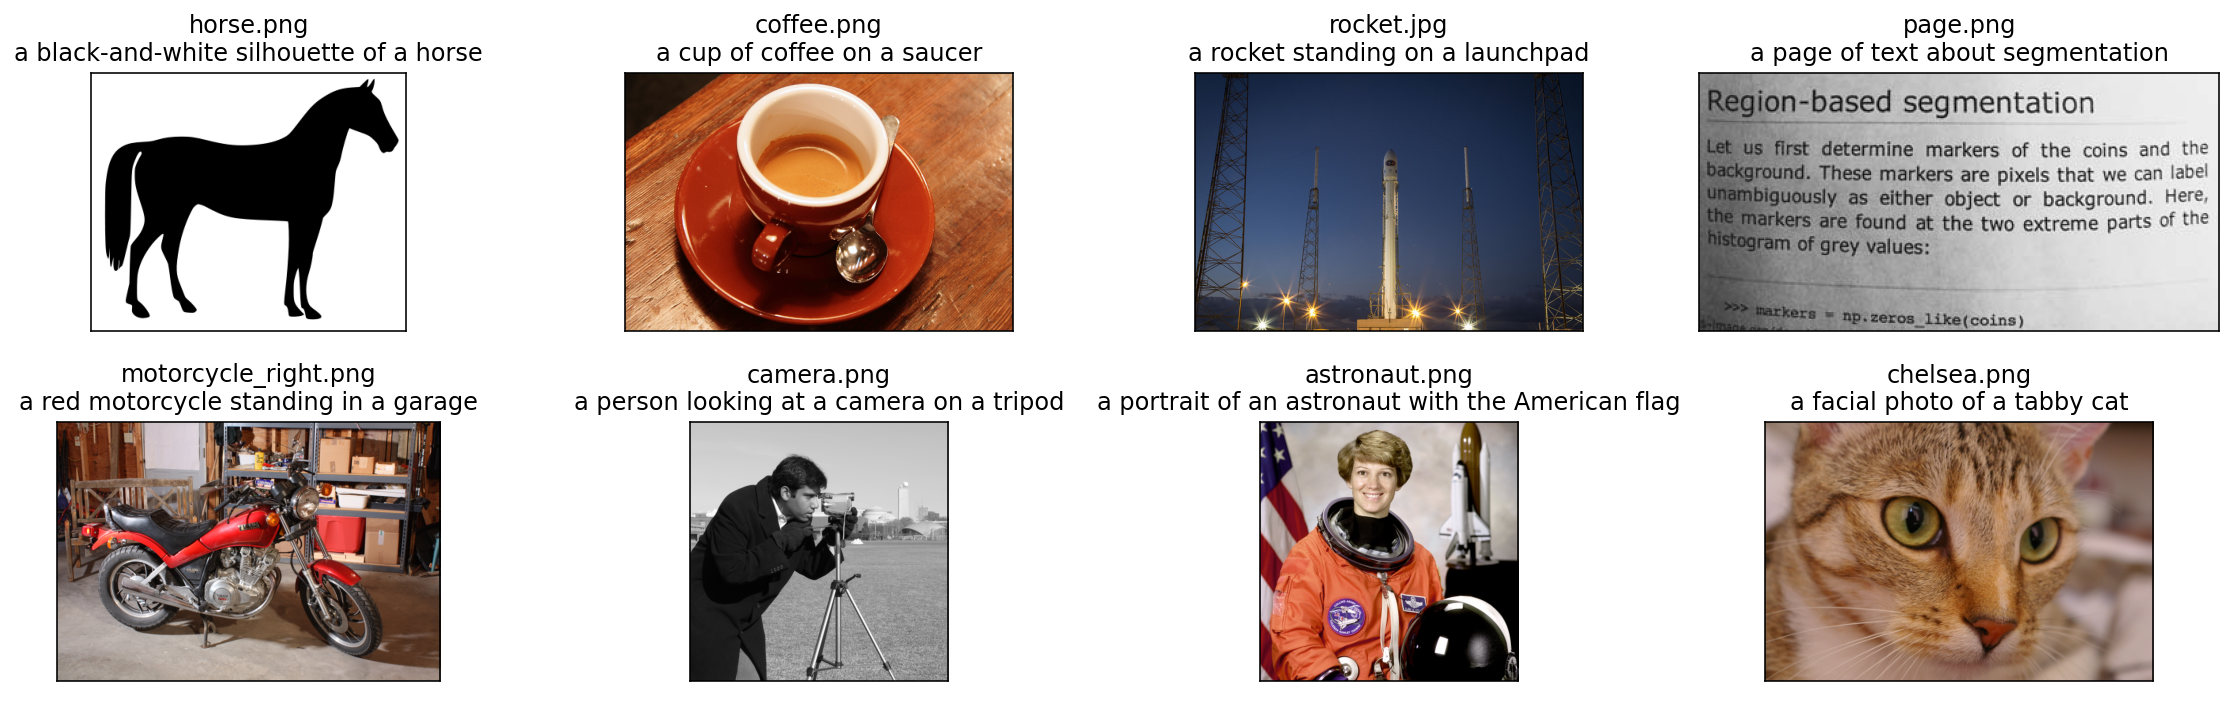

In [43]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(fe(image)["pixel_values"])
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [44]:
image_input = fe(original_images, return_tensors="pt").to("cuda")
text_tokens = tokenizer(["This is " + desc for desc in texts], return_tensors="pt", padding=True, max_length=77).to("cuda")

In [45]:
with torch.no_grad():
    # We take the output embedding for the CLS token for both encoders
    image_features = flava.get_image_features(**image_input)[:, 0].float()
    text_features = flava.get_text_features(**text_tokens)[:, 0].float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [46]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

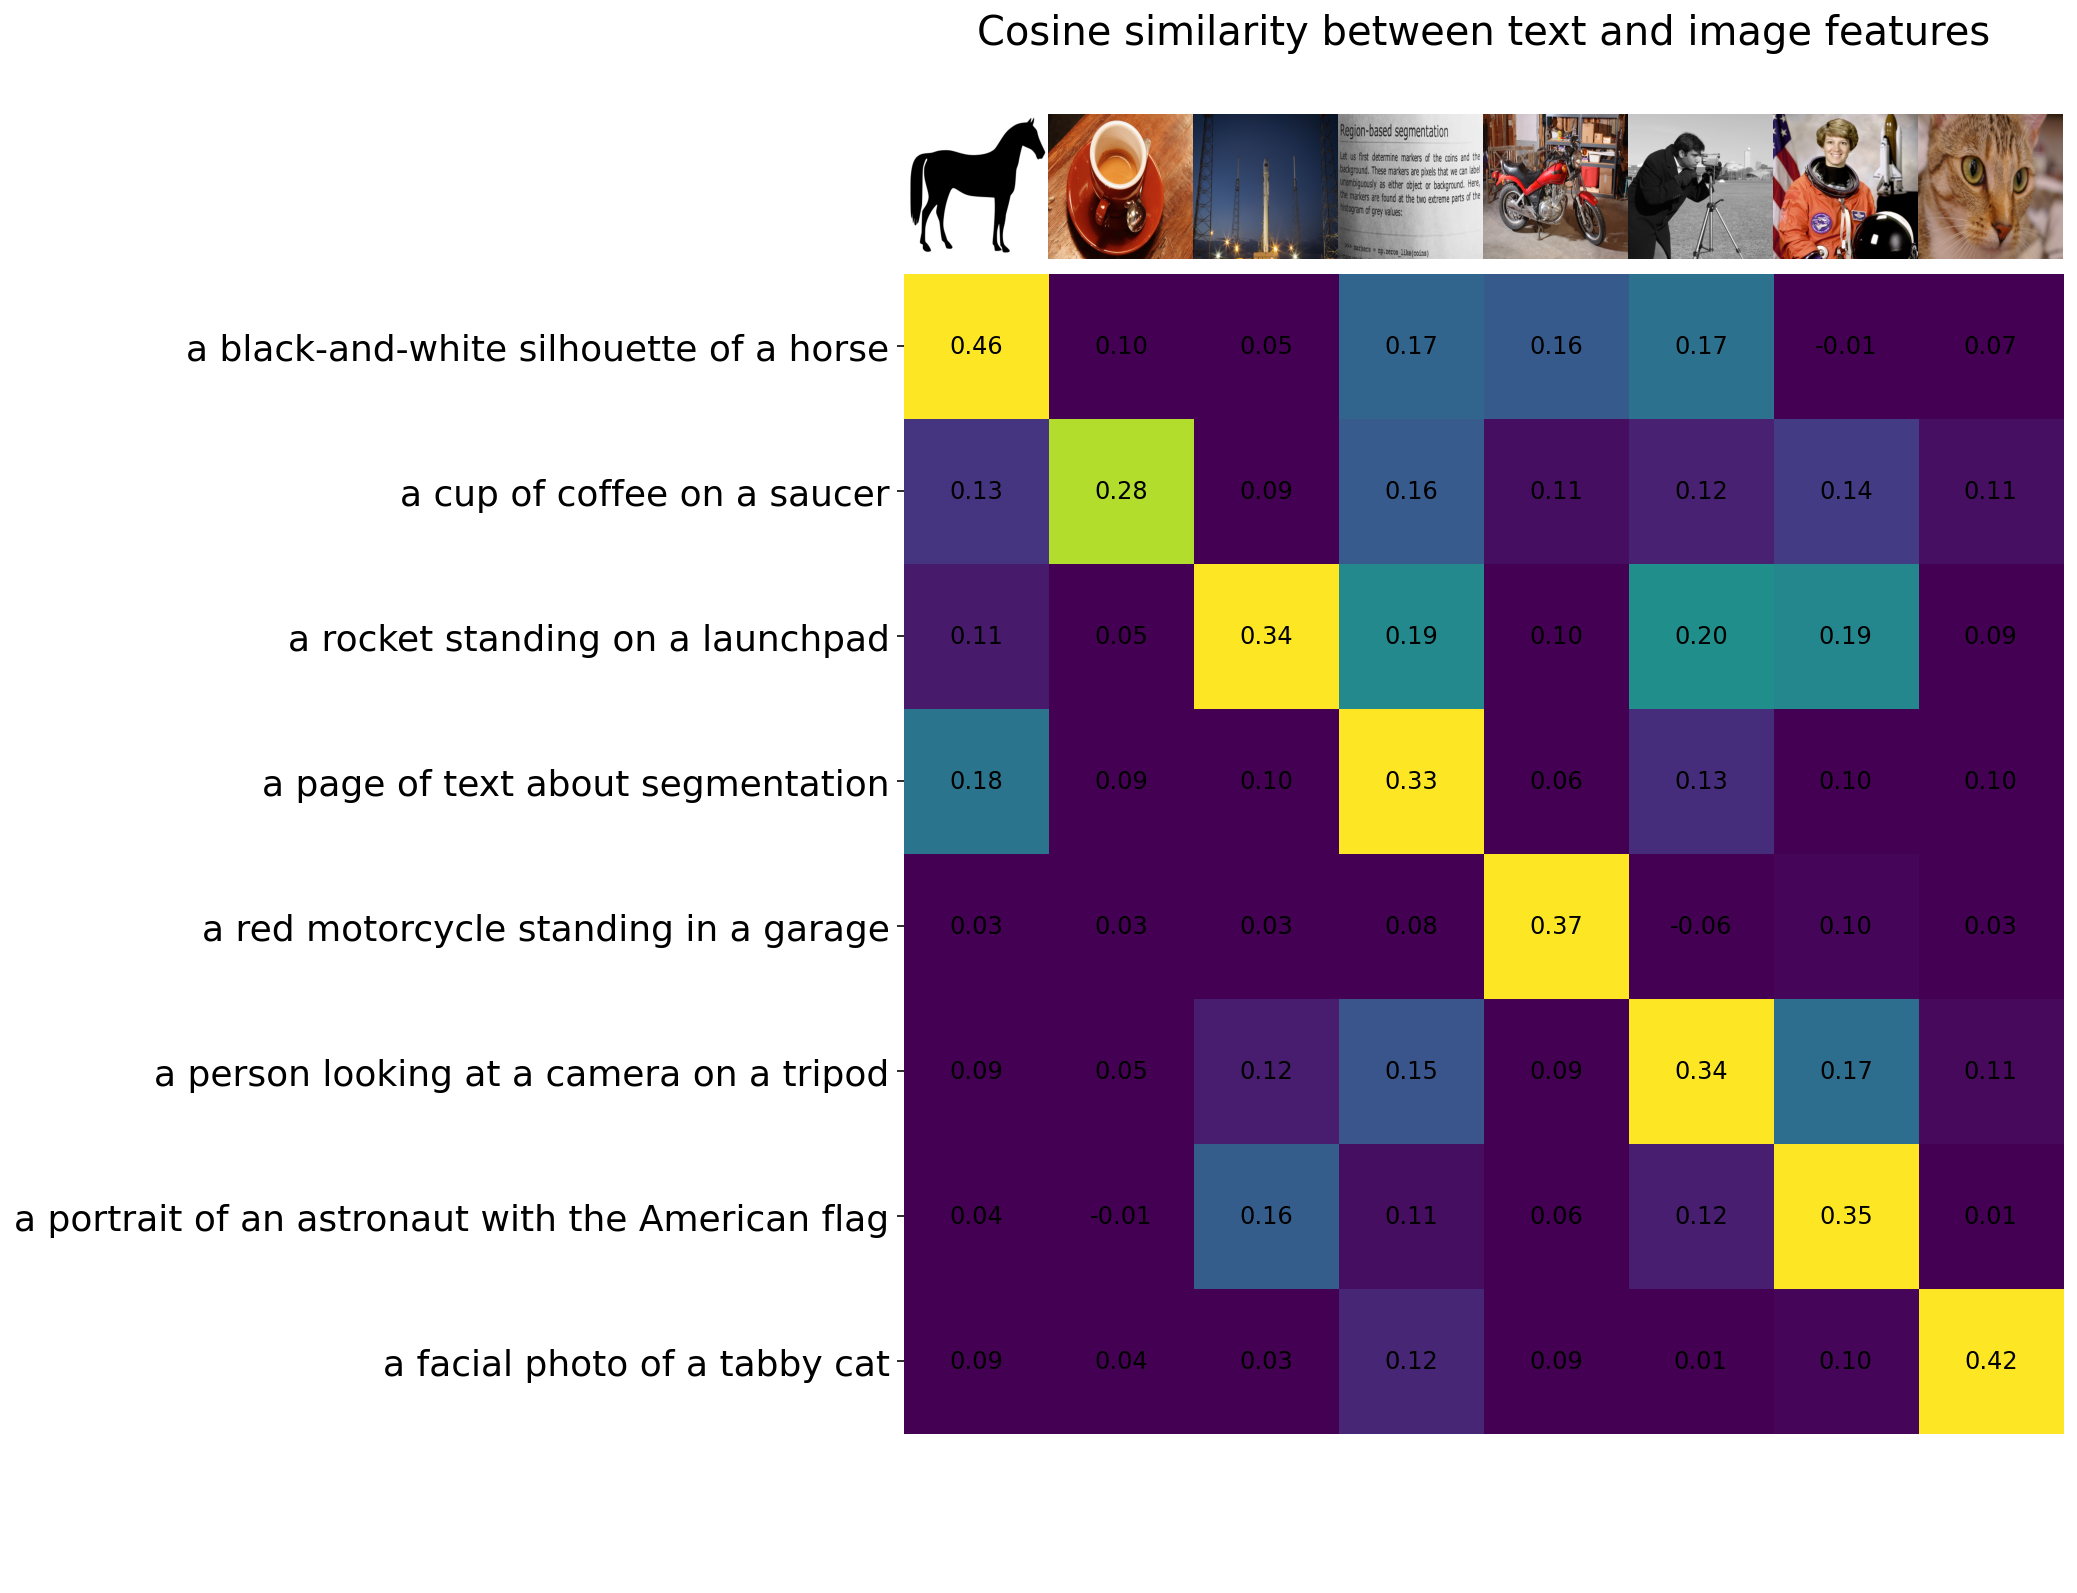

In [47]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [48]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), download=True)

Files already downloaded and verified


In [49]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = tokenizer(text_descriptions, padding=True, max_length=77, return_tensors="pt").to("cuda")

In [50]:
with torch.no_grad():
    text_features = flava.get_text_features(**text_tokens)[:, 0, :].float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

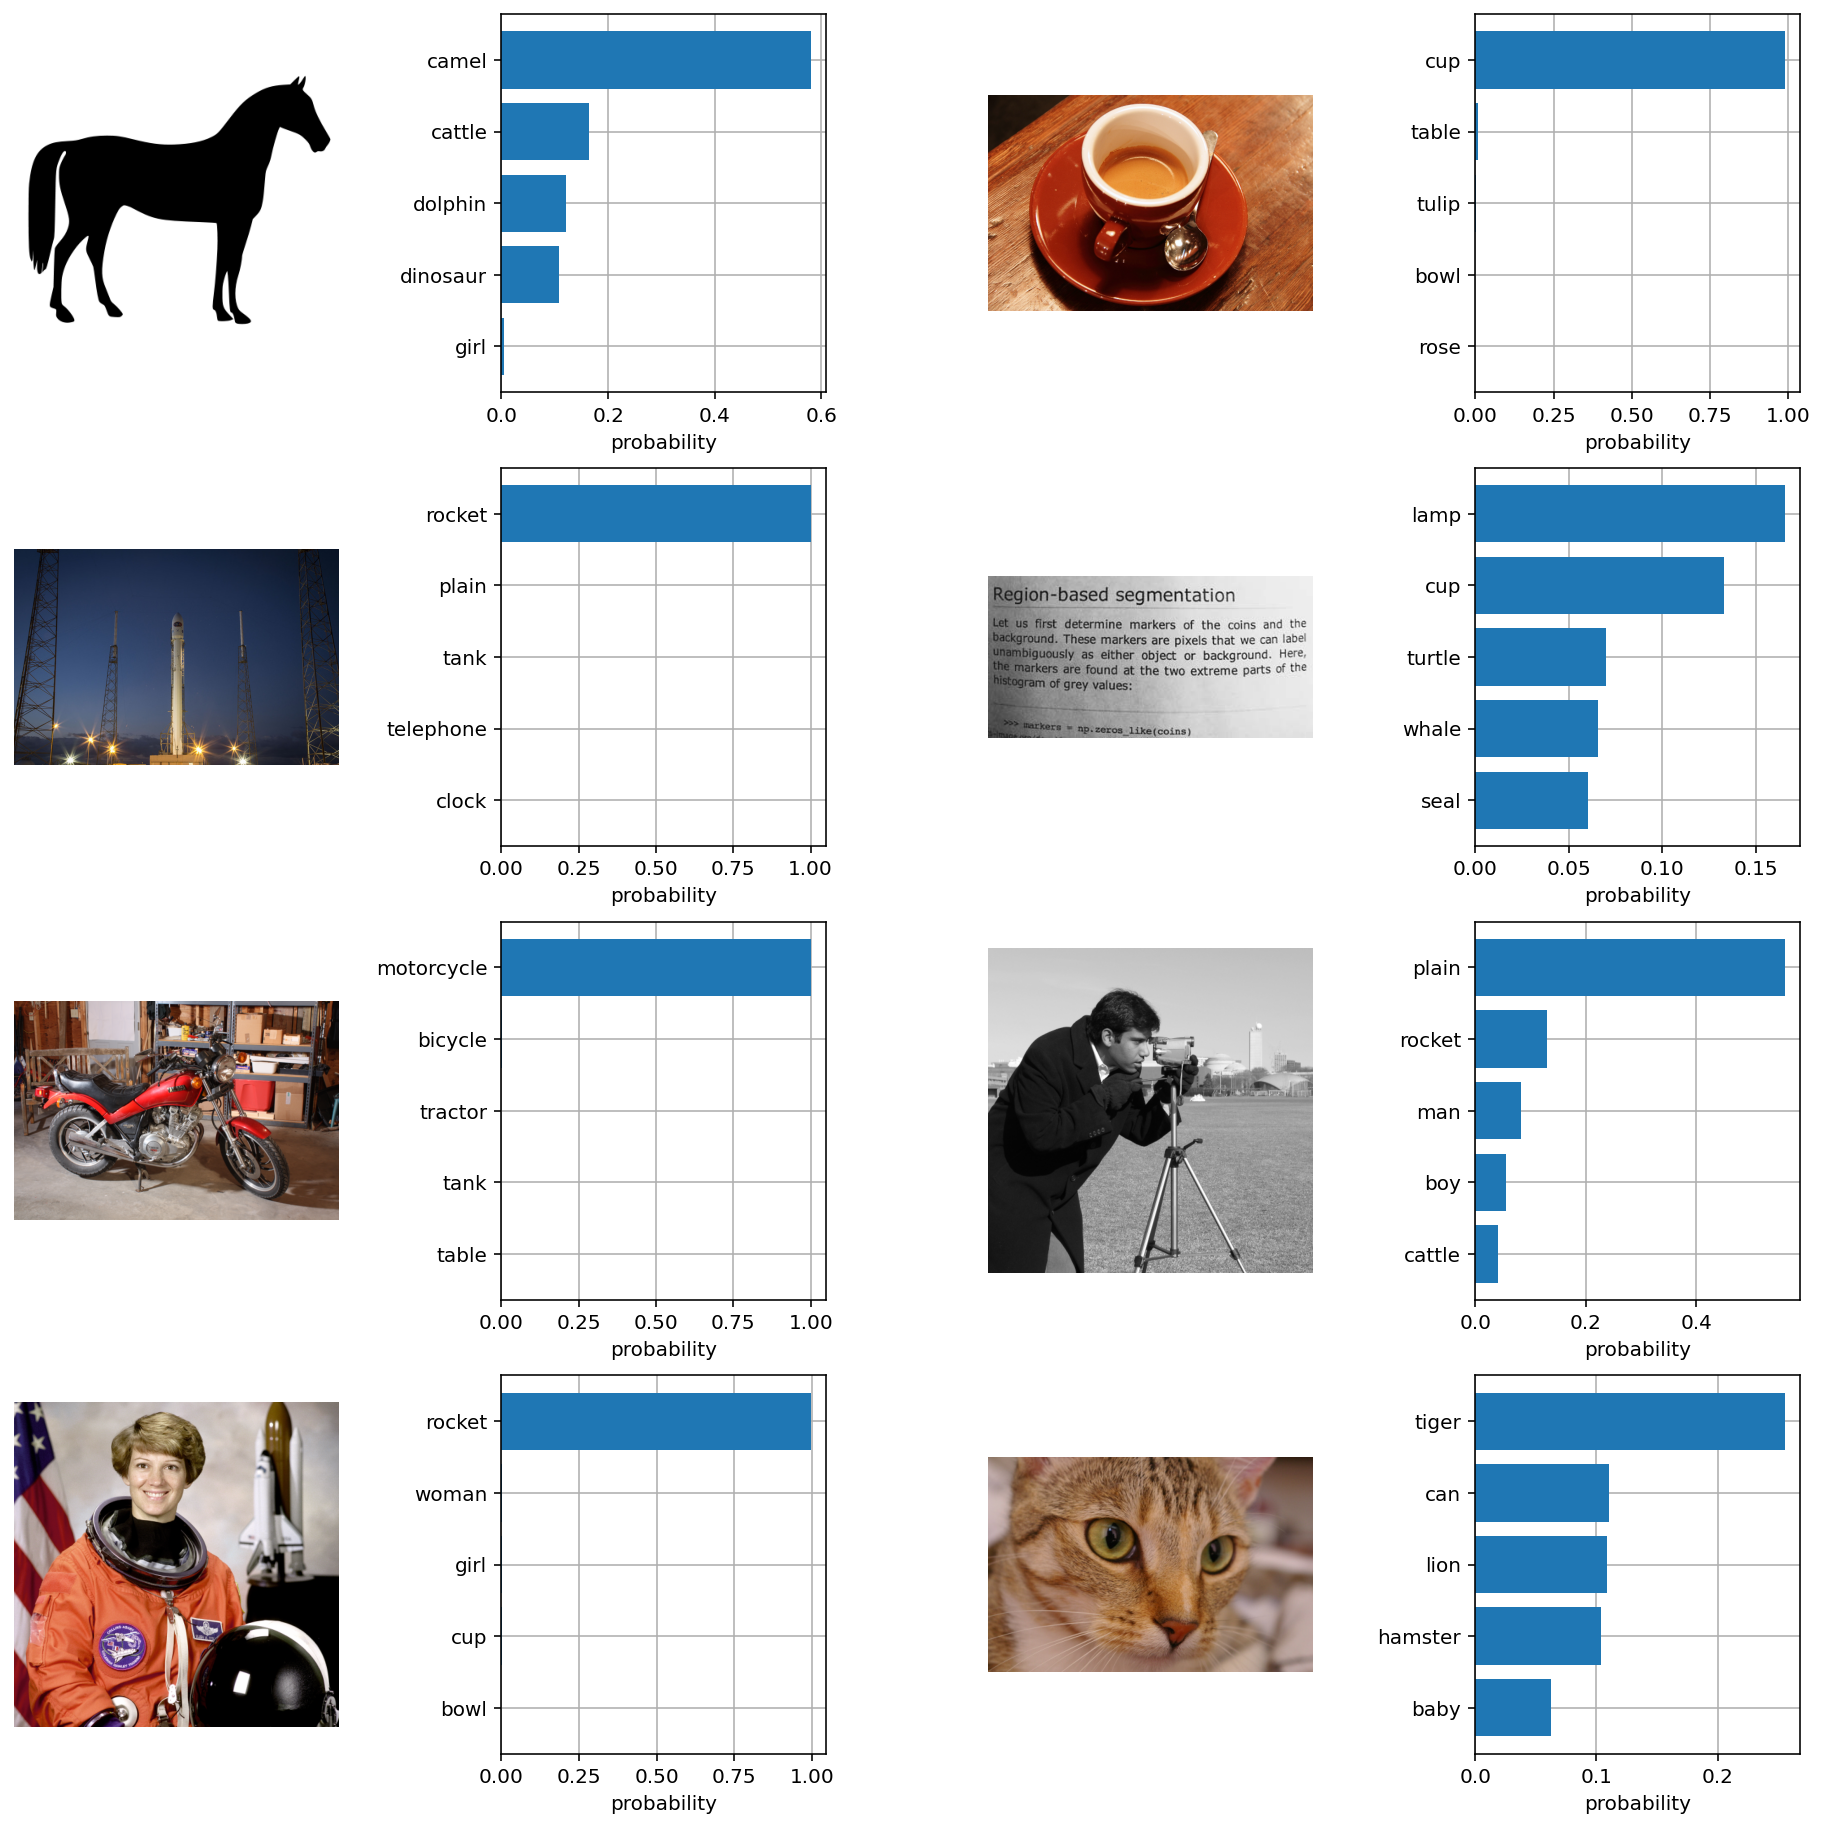

In [51]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()